# Sweep Tone Analysis

**Author: Xavier Lizarraga**

Sine sweeps are used as reference tones to estimate the frequency response of a system. They are well known in Acoustics, to analyze the room impulse response and room modes (resonances). Compared to pink noise or white noise, sine sweeps produce frequencies with a much higher energy, as they dedicate the fully available dynamic to play one frequency at a time, not simultaneous frequencies like noise. This gives sine sweeps a better immunity against room ambience and background noises. 

To estimate the frequency response with a sweep tone there are different approaches, for instance with an Spectrum Analyzer with PEAK HOLD you can see the frequency curve. 

However there are methods proposed by [Angelo Farina](https://melaudia.net/zdoc/sweepSine.PDF) that assume a proper inverse filter `f(t)` can be capable of packing the input signal `x(t)` into a delayed Dirac’s delta function `δ(t)` (impulse response aka IR). So, `f(t)` lets us extract the impulse response by `x(t) * f(t) = δ(t)`. Nevertheless the transfer function of a system (frequency response) is defined by `H(w) = Y(w) / X(w) = FFT(x(t)) / FFT(y(t))` where `x(t)` and `y(t)` are respectively the impulse response for the input and output of the system {cite:p}`farina2000simultaneous`. 

## Impulse Response Estimation 
To estimate the impulse response with a sine sweep:
1. Generate the test signal (sine sweep - `x(t)`) and its inverse filter `f(t)`.
2. To obtain `y(t)`, process the sweep with the system. For `x(t)`, there is no process. So, you can jump in this step.
3. Convolve the sine sweep with its inverse filter. The sweep and the inverse filter should be defined with the same parameters (sampling rate, duration and bandwidth).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

You will need to generate the test signals `x(t)`, a sweep tone `x(t) = sin(g(t))`, and its inverse filter `f(t)`.

In [2]:
# You will need a sine tone generator
def sine(sample_rate: int, duration: float, amplitude: float, frequency: float = 440.0) -> np.ndarray:
    N = np.arange(0, duration, 1.0 / sample_rate)
    return amplitude * np.sin(2.0 * np.pi * frequency * N)

# You will need a sweep tone generator
def sweep_tone(
    sample_rate: int,
    duration: float,
    amplitude: float,
    f0: float = 20,
    f1: float = 20000,
    inverse: bool = False,
) -> np.ndarray:
    """
    Generates a sweep tone.
    Args:
        sample_rate (int): Sample rate
        duration (float): Duration
        amplitude (float): Amplitude
        f0 (float): Start frequency. Defaults to 20Hz
        f1 (float, optional): End frequency. Defaults to 20k.
        inverse: (bool, optional): Generate the inverse filter. Defaults to False
    """
    R = np.log(f1 / f0)
    t = np.arange(0, duration, 1.0 / sample_rate)
    output = np.sin((2.0 * np.pi * f0 * duration / R) * (np.exp(t * R / duration) - 1))
    if inverse:
        k = np.exp(t * R / duration)
        output = output[::-1] / k
    return amplitude * output

You will need some parameters to generate the sine sweep and its inverse filter

In [3]:
SAMPLE_RATE = 48000
duration = 5
decibels = -18
amplitude = 10 ** (decibels / 20)
f0 = 5
f1 = SAMPLE_RATE / 2

## 1. Impulse Response Estimation

The impulse response is obtained by the convolution of the test signal and its inverse filter `x(t) * f(t) = δ(t)`. When the sweep is not altered the delta dirac should be almost perfect. The quality of the estimated impulse response might depends on the bandwidth and its duration.

In [4]:
# Generates a sweep tone
sweep = sweep_tone(SAMPLE_RATE, duration, amplitude, f0=f0, f1=f1)

# Generates its inverse filter
inverse_filter = sweep_tone(SAMPLE_RATE, duration, amplitude, f0=f0, f1=f1, inverse=True)

In [5]:
# Convolves the sweep tone with the inverse filter in order to obtain the impulse response x(t)
N = len(sweep)
reference = np.convolve(sweep, inverse_filter)

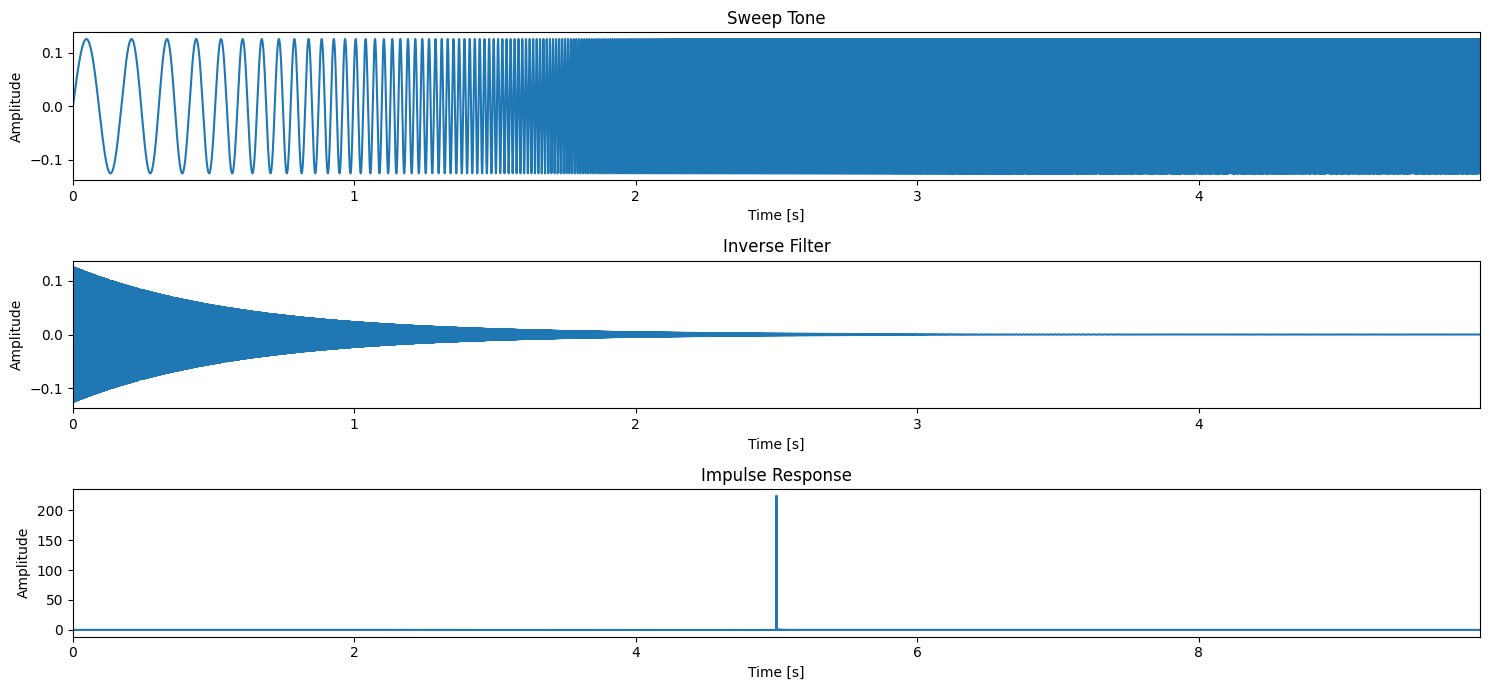

In [6]:
# Display signals
time_stamps = np.arange(0, duration, 1/SAMPLE_RATE)
fig, ax = plt.subplots(3, 1, figsize=(15,7))
ax[0].plot(time_stamps, sweep)
ax[0].set_xlim([0, time_stamps[-1]])
ax[0].set_title("Sweep Tone")
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Amplitude")
ax[1].plot(time_stamps, inverse_filter)
ax[1].set_xlim([0, time_stamps[-1]])
ax[1].set_title("Inverse Filter")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Amplitude")
time_stamps = np.arange(0, len(reference)/SAMPLE_RATE, 1/SAMPLE_RATE)
ax[2].plot(time_stamps, reference)
ax[2].set_xlim([0, time_stamps[-1]])
ax[2].set_title("Impulse Response")
ax[2].set_xlabel("Time [s]")
ax[2].set_ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [7]:
# Define parameters
cutoff = 720  # Cutoff frequency in Hz
SAMPLE_RATE = 44100  # Example sample rate, adjust as needed

# Design a first-order low-pass filter using scipy
b, a = scipy.signal.butter(1, cutoff / (SAMPLE_RATE / 2), btype='low', analog=False)

# Filter the sweep signal
sweep_filt = scipy.signal.lfilter(b, a, sweep)

# Convolve with the inverse filter
measured = np.convolve(sweep_filt, inverse_filter)


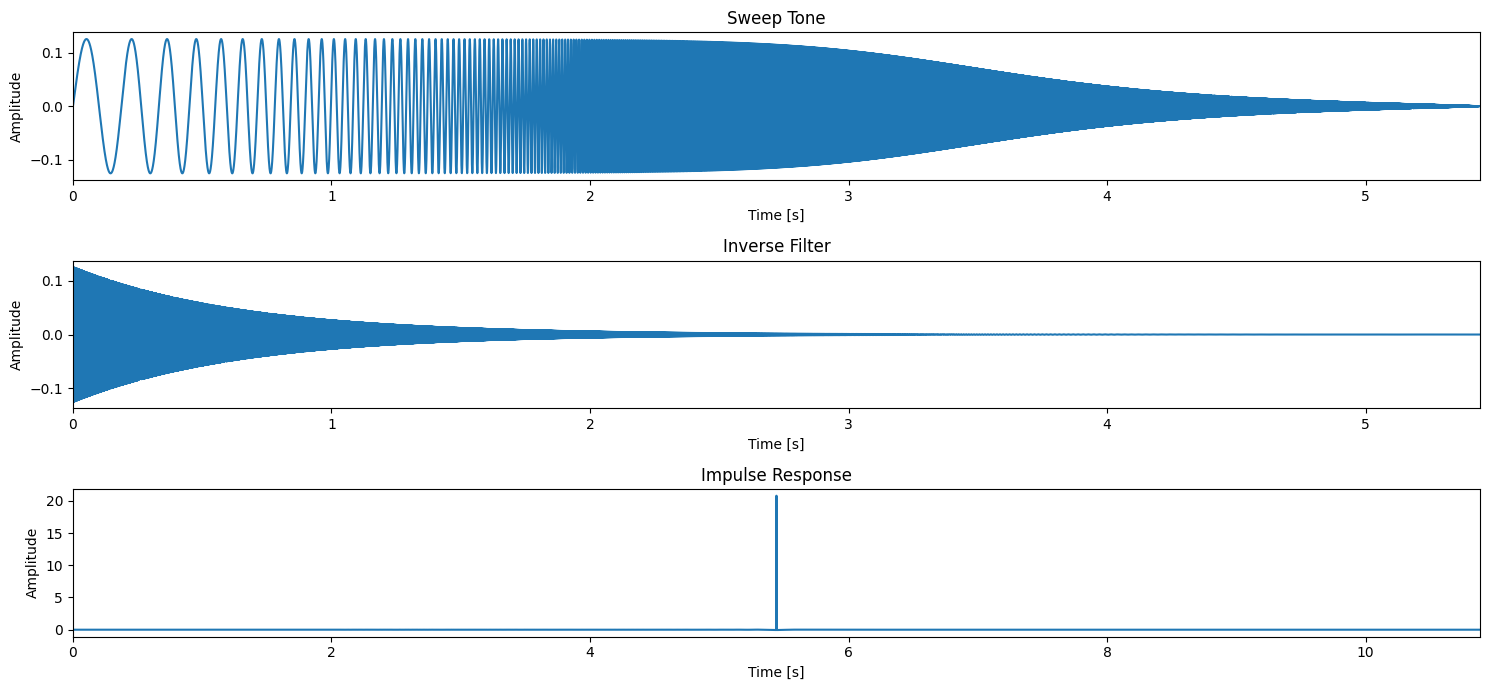

In [9]:
# Define time axis correctly
time_stamps_sweep = np.arange(0, len(sweep_filt) / SAMPLE_RATE, 1 / SAMPLE_RATE)
time_stamps_inverse = np.arange(0, len(inverse_filter) / SAMPLE_RATE, 1 / SAMPLE_RATE)
time_stamps_measured = np.arange(0, len(measured) / SAMPLE_RATE, 1 / SAMPLE_RATE)

fig, ax = plt.subplots(3, 1, figsize=(15, 7))

ax[0].plot(time_stamps_sweep, sweep_filt)
ax[0].set_xlim([0, time_stamps_sweep[-1]])
ax[0].set_title("Sweep Tone")
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Amplitude")

ax[1].plot(time_stamps_inverse, inverse_filter)
ax[1].set_xlim([0, time_stamps_inverse[-1]])
ax[1].set_title("Inverse Filter")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Amplitude")

ax[2].plot(time_stamps_measured, measured)
ax[2].set_xlim([0, time_stamps_measured[-1]])
ax[2].set_title("Impulse Response")
ax[2].set_xlabel("Time [s]")
ax[2].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


You will need some functionalities to estimate the transfer function 

`H(w) = FFT(y(t)) / FFT(x(t))`

In [10]:
def fft_scipy(x: np.ndarray, fft_size: int, axis: int = -1) -> np.ndarray:
    hM1 = int(np.floor((fft_size + 1) / 2))  # half analysis window size by rounding
    hM2 = int(np.floor(fft_size / 2))  # half analysis window size by floor
    hN = int((fft_size / 2) - 1)
    fft_buffer = np.zeros(shape=(fft_size,))  # initialize buffer for FFT
    fft_buffer[:hM1] = x[hM2:]
    fft_buffer[-hM2:] = x[:hM2]
    return scipy.fftpack.fft(fft_buffer, fft_size, axis=axis)[:hN]

def transfer_function(x: np.ndarray, y: np.ndarray):
    X = fft_scipy(x, len(measured))  # X(w)
    Y = fft_scipy(y, len(measured))  # Y(w)
    return Y / X                       # Y(w) / X(w)

In [11]:
# We will compute the transfer function
tf = transfer_function(reference, measured)
magnitude = 20* np.log10(np.abs(tf))
phase = np.angle(tf) * 180 / np.pi

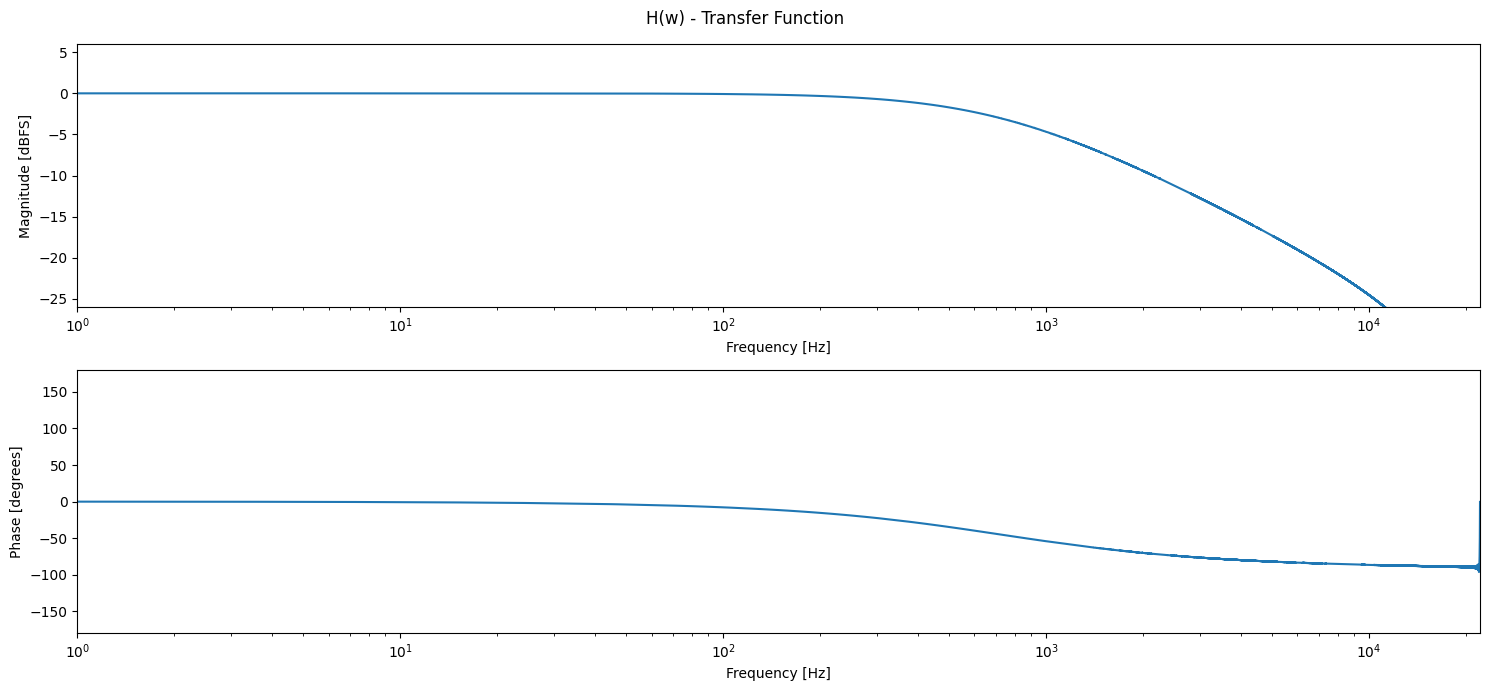

In [12]:
freqs = np.linspace(0, SAMPLE_RATE/2, int(len(measured)/2)-1)
fig, ax = plt.subplots(2, 1, figsize=(15,7))
ax[0].semilogx(freqs, magnitude)
ax[0].set_xlim([1, freqs[-1]])
ax[0].set_ylim([-26, 6])
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Magnitude [dBFS]")
ax[1].semilogx(freqs, phase)
ax[1].set_xlim([1, freqs[-1]])
ax[1].set_ylim([-180, 180])
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Phase [degrees]")
plt.suptitle("H(w) - Transfer Function")
plt.tight_layout()
plt.show()